In [1]:
# Import libs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import os 
import sys
import random
from tqdm import tqdm

from keras.models import Model, load_model
from keras.layers import Input, merge, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Dense
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers

import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.random.seed = 1337

# Set operating parameters
TRAIN_IMG_PATH = 'training_hair_skin\images'
VALID_IMG_PATH = 'validation_hair_skin\images'
TEST_IMG_PATH = 'testing_images'
TRAIN_MASK_PATH = 'training_masks'

IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

NUM_EPOCHS = 50
BATCH_SIZE = 100 #3

In [3]:
# Get list of training and testing filenames
train_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_IMG_PATH))[2]
train_masks = next(os.walk(TRAIN_MASK_PATH))[2]

print(train_ids)
#print(test_ids)
print(train_masks)

['train_img_1.jpg', 'train_img_10.jpg', 'train_img_100.jpg', 'train_img_1000.jpg', 'train_img_1001.jpg', 'train_img_1002.jpg', 'train_img_1003.jpg', 'train_img_1004.jpg', 'train_img_1005.jpg', 'train_img_1006.jpg', 'train_img_1007.jpg', 'train_img_1008.jpg', 'train_img_1009.jpg', 'train_img_101.jpg', 'train_img_1010.jpg', 'train_img_1011.jpg', 'train_img_1012.jpg', 'train_img_1013.jpg', 'train_img_1014.jpg', 'train_img_1015.jpg', 'train_img_1016.jpg', 'train_img_1017.jpg', 'train_img_1018.jpg', 'train_img_1019.jpg', 'train_img_102.jpg', 'train_img_1020.jpg', 'train_img_1021.jpg', 'train_img_1022.jpg', 'train_img_1023.jpg', 'train_img_1024.jpg', 'train_img_1025.jpg', 'train_img_1026.jpg', 'train_img_1027.jpg', 'train_img_1028.jpg', 'train_img_1029.jpg', 'train_img_103.jpg', 'train_img_1030.jpg', 'train_img_1031.jpg', 'train_img_1032.jpg', 'train_img_1033.jpg', 'train_img_1034.jpg', 'train_img_1035.jpg', 'train_img_1036.jpg', 'train_img_1037.jpg', 'train_img_1038.jpg', 'train_img_1039.jp


['train_mask_1.jpg', 'train_mask_10.jpg', 'train_mask_100.jpg', 'train_mask_1000.jpg', 'train_mask_1001.jpg', 'train_mask_1002.jpg', 'train_mask_1003.jpg', 'train_mask_1004.jpg', 'train_mask_1005.jpg', 'train_mask_1006.jpg', 'train_mask_1007.jpg', 'train_mask_1008.jpg', 'train_mask_1009.jpg', 'train_mask_101.jpg', 'train_mask_1010.jpg', 'train_mask_1011.jpg', 'train_mask_1012.jpg', 'train_mask_1013.jpg', 'train_mask_1014.jpg', 'train_mask_1015.jpg', 'train_mask_1016.jpg', 'train_mask_1017.jpg', 'train_mask_1018.jpg', 'train_mask_1019.jpg', 'train_mask_102.jpg', 'train_mask_1020.jpg', 'train_mask_1021.jpg', 'train_mask_1022.jpg', 'train_mask_1023.jpg', 'train_mask_1024.jpg', 'train_mask_1025.jpg', 'train_mask_1026.jpg', 'train_mask_1027.jpg', 'train_mask_1028.jpg', 'train_mask_1029.jpg', 'train_mask_103.jpg', 'train_mask_1030.jpg', 'train_mask_1031.jpg', 'train_mask_1032.jpg', 'train_mask_1033.jpg', 'train_mask_1034.jpg', 'train_mask_1035.jpg', 'train_mask_1036.jpg', 'train_mask_1037.j

In [4]:
# Get and resize training images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing training images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

# Get and resize training mask images
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_masks), total=len(train_masks)):
    path = TRAIN_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 149.34it/s]


Getting and resizing training masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 408.94it/s]


Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 927/927 [00:05<00:00, 166.85it/s]


Done!


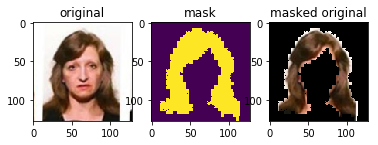

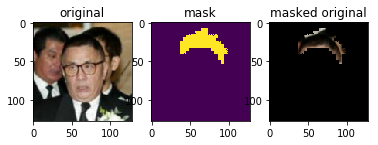

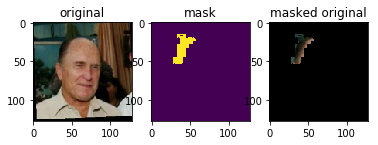

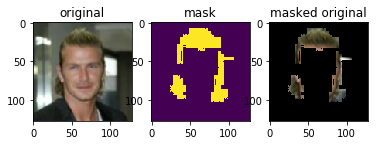

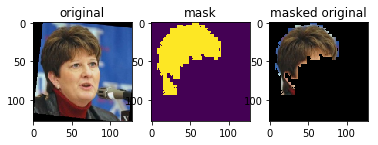

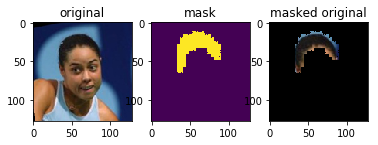

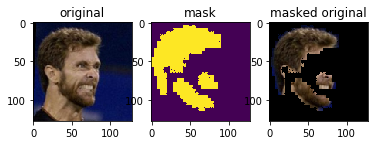

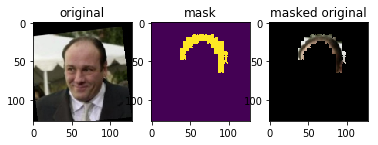

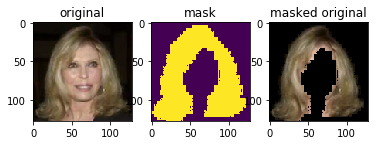

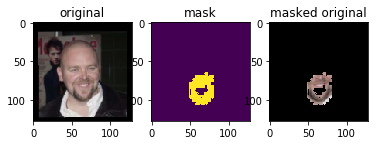

In [5]:
# Check if training and mask data looks all right
for ix in np.arange(10):
    # Mask should be a 2D array for plot
    mask = np.squeeze(Y_train[ix])

    # Create a masked image
    masked = np.copy(X_train[ix]) * Y_train[ix]
    
    # Display original, mask, and masked images side-by-side
    f, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.set_title('original')
    ax0.imshow(X_train[ix])
    ax1.set_title('mask')
    ax1.imshow(mask)
    ax2.set_title('masked original')
    ax2.imshow(masked)
    plt.show()

In [6]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
# Define a U-Net neural network
def unet(height, width, num_channels):
    inputs = Input((height, width, num_channels))
    inputs_ = Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [9]:
# Build U-Net model
model = unet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

adam = optimizers.Adam(lr=0.0019, decay =0.0) #adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[mean_iou])

# Fit model
earlystopper = EarlyStopping(patience=20, verbose=2)
checkpointer = ModelCheckpoint('model-hair-1.h5', save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=40, epochs=50, 
                    callbacks=[earlystopper, checkpointer]) # verbose=1(before save_best_only = True) batch_size=8, epochs=10

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - ETA: 2:27 - loss: 7.5777 - mean_iou: 0.0000e+ - ETA: 2:16 - loss: 4.8825 - mean_iou: 0.0662   - ETA: 2:08 - loss: 3.6686 - mean_iou: 0.11 - ETA: 2:03 - loss: 3.0822 - mean_iou: 0.16 - ETA: 1:59 - loss: 2.7448 - mean_iou: 0.20 - ETA: 1:54 - loss: 2.5660 - mean_iou: 0.23 - ETA: 1:49 - loss: 2.4035 - mean_iou: 0.25 - ETA: 1:45 - loss: 2.2987 - mean_iou: 0.27 - ETA: 1:40 - loss: 2.2068 - mean_iou: 0.28 - ETA: 1:36 - loss: 2.1172 - mean_iou: 0.30 - ETA: 1:31 - loss: 2.0641 - mean_iou: 0.31 - ETA: 1:26 - loss: 1.9734 - mean_iou: 0.32 - ETA: 1:22 - loss: 1.8905 - mean_iou: 0.32 - ETA: 1:17 - loss: 1.8105 - mean_iou: 0.33 - ETA: 1:12 - loss: 1.7272 - mean_iou: 0.34 - ETA: 1:07 - loss: 1.6549 - mean_iou: 0.34 - ETA: 1:02 - loss: 1.5899 - mean_iou: 0.35 - ETA: 58s - loss: 1.5293 - mean_iou: 0.3550 - ETA: 53s - loss: 1.4736 - mean_iou: 0.358 - ETA: 48s - loss: 1.4239 - mean_iou: 0.362 - ETA: 43s

1200/1200 [==============================] - ETA: 2:26 - loss: 0.2416 - mean_iou: 0.49 - ETA: 2:19 - loss: 0.2076 - mean_iou: 0.49 - ETA: 2:14 - loss: 0.2147 - mean_iou: 0.49 - ETA: 2:09 - loss: 0.2099 - mean_iou: 0.49 - ETA: 2:04 - loss: 0.2098 - mean_iou: 0.49 - ETA: 1:59 - loss: 0.2069 - mean_iou: 0.49 - ETA: 1:54 - loss: 0.2013 - mean_iou: 0.49 - ETA: 1:49 - loss: 0.2053 - mean_iou: 0.49 - ETA: 1:44 - loss: 0.1996 - mean_iou: 0.49 - ETA: 1:39 - loss: 0.1971 - mean_iou: 0.49 - ETA: 1:34 - loss: 0.1942 - mean_iou: 0.49 - ETA: 1:29 - loss: 0.1934 - mean_iou: 0.49 - ETA: 1:24 - loss: 0.1923 - mean_iou: 0.49 - ETA: 1:19 - loss: 0.1954 - mean_iou: 0.49 - ETA: 1:14 - loss: 0.1951 - mean_iou: 0.49 - ETA: 1:09 - loss: 0.1955 - mean_iou: 0.49 - ETA: 1:04 - loss: 0.1943 - mean_iou: 0.49 - ETA: 59s - loss: 0.1975 - mean_iou: 0.4968 - ETA: 54s - loss: 0.1979 - mean_iou: 0.496 - ETA: 49s - loss: 0.2001 - mean_iou: 0.497 - ETA: 44s - loss: 0.2018 - mean_iou: 0.497 - ETA: 39s - loss: 0.2016 - mean

1200/1200 [==============================] - ETA: 2:35 - loss: 0.1340 - mean_iou: 0.58 - ETA: 2:21 - loss: 0.1277 - mean_iou: 0.58 - ETA: 2:13 - loss: 0.1296 - mean_iou: 0.58 - ETA: 2:07 - loss: 0.1289 - mean_iou: 0.58 - ETA: 2:02 - loss: 0.1294 - mean_iou: 0.58 - ETA: 1:57 - loss: 0.1290 - mean_iou: 0.58 - ETA: 1:52 - loss: 0.1325 - mean_iou: 0.58 - ETA: 1:47 - loss: 0.1300 - mean_iou: 0.58 - ETA: 1:42 - loss: 0.1293 - mean_iou: 0.58 - ETA: 1:37 - loss: 0.1285 - mean_iou: 0.58 - ETA: 1:32 - loss: 0.1285 - mean_iou: 0.58 - ETA: 1:28 - loss: 0.1286 - mean_iou: 0.58 - ETA: 1:23 - loss: 0.1284 - mean_iou: 0.58 - ETA: 1:18 - loss: 0.1277 - mean_iou: 0.58 - ETA: 1:13 - loss: 0.1286 - mean_iou: 0.58 - ETA: 1:08 - loss: 0.1277 - mean_iou: 0.59 - ETA: 1:03 - loss: 0.1285 - mean_iou: 0.59 - ETA: 58s - loss: 0.1298 - mean_iou: 0.5903 - ETA: 53s - loss: 0.1287 - mean_iou: 0.590 - ETA: 48s - loss: 0.1281 - mean_iou: 0.590 - ETA: 44s - loss: 0.1293 - mean_iou: 0.590 - ETA: 39s - loss: 0.1287 - mean

1200/1200 [==============================] - ETA: 2:24 - loss: 0.1012 - mean_iou: 0.64 - ETA: 2:15 - loss: 0.1040 - mean_iou: 0.64 - ETA: 2:10 - loss: 0.1006 - mean_iou: 0.64 - ETA: 2:04 - loss: 0.0977 - mean_iou: 0.64 - ETA: 2:00 - loss: 0.0940 - mean_iou: 0.64 - ETA: 1:55 - loss: 0.0951 - mean_iou: 0.64 - ETA: 1:50 - loss: 0.0945 - mean_iou: 0.64 - ETA: 1:45 - loss: 0.0932 - mean_iou: 0.64 - ETA: 1:40 - loss: 0.0927 - mean_iou: 0.64 - ETA: 1:36 - loss: 0.0916 - mean_iou: 0.64 - ETA: 1:31 - loss: 0.0918 - mean_iou: 0.64 - ETA: 1:26 - loss: 0.0925 - mean_iou: 0.64 - ETA: 1:21 - loss: 0.0923 - mean_iou: 0.64 - ETA: 1:18 - loss: 0.0925 - mean_iou: 0.64 - ETA: 1:14 - loss: 0.0913 - mean_iou: 0.64 - ETA: 1:10 - loss: 0.0903 - mean_iou: 0.64 - ETA: 1:05 - loss: 0.0897 - mean_iou: 0.64 - ETA: 1:01 - loss: 0.0903 - mean_iou: 0.64 - ETA: 56s - loss: 0.0900 - mean_iou: 0.6483 - ETA: 51s - loss: 0.0906 - mean_iou: 0.648 - ETA: 46s - loss: 0.0908 - mean_iou: 0.648 - ETA: 42s - loss: 0.0904 - mean

1200/1200 [==============================] - ETA: 2:51 - loss: 0.0651 - mean_iou: 0.68 - ETA: 2:56 - loss: 0.0629 - mean_iou: 0.68 - ETA: 2:46 - loss: 0.0609 - mean_iou: 0.68 - ETA: 2:39 - loss: 0.0612 - mean_iou: 0.68 - ETA: 2:32 - loss: 0.0614 - mean_iou: 0.69 - ETA: 2:25 - loss: 0.0609 - mean_iou: 0.69 - ETA: 2:24 - loss: 0.0604 - mean_iou: 0.69 - ETA: 2:19 - loss: 0.0626 - mean_iou: 0.69 - ETA: 2:12 - loss: 0.0628 - mean_iou: 0.69 - ETA: 2:06 - loss: 0.0628 - mean_iou: 0.69 - ETA: 2:01 - loss: 0.0620 - mean_iou: 0.69 - ETA: 1:55 - loss: 0.0617 - mean_iou: 0.69 - ETA: 1:49 - loss: 0.0615 - mean_iou: 0.69 - ETA: 1:43 - loss: 0.0617 - mean_iou: 0.69 - ETA: 1:37 - loss: 0.0618 - mean_iou: 0.69 - ETA: 1:31 - loss: 0.0614 - mean_iou: 0.69 - ETA: 1:24 - loss: 0.0616 - mean_iou: 0.69 - ETA: 1:18 - loss: 0.0622 - mean_iou: 0.69 - ETA: 1:11 - loss: 0.0623 - mean_iou: 0.69 - ETA: 1:04 - loss: 0.0625 - mean_iou: 0.69 - ETA: 58s - loss: 0.0625 - mean_iou: 0.6908 - ETA: 51s - loss: 0.0627 - mean

In [14]:
# Predict on train, val and test
model = load_model('model-skin-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.50).astype(np.uint8)
preds_val_t = (preds_val > 0.50).astype(np.uint8)
preds_test_t = (preds_test > 0.50).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

927/927 [==============================] - ETA: 44 - ETA: 40 - ETA: 38 - ETA: 37 - ETA: 35 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 28 - ETA: 27 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 17 - ETA: 16 - ETA: 14 - ETA: 13 - ETA: 11 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 42s 45ms/step


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


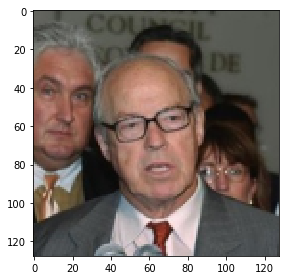

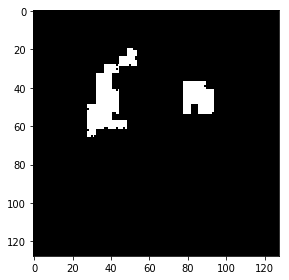

C:\Users\Ashish\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


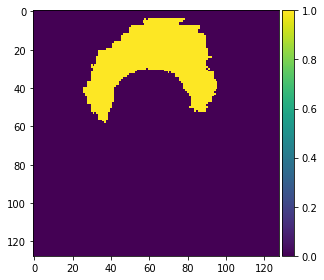

In [15]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from scipy.misc import imread, imresize, imsave
%matplotlib inline  


# Save masks to output folder
test_ids_ = list(map(lambda x:x.replace('img','mask'),test_ids)) # Convenience, rename the file name list

# Properly shape all test-prediction masks and save them
for i in np.arange(len(preds_test_t)):
    mask_ = np.squeeze(preds_test_t[i])
    mask_ = np.array(mask_*255, dtype='uint8')
    mask_ = imresize(mask_, size=sizes_test[i]) # upsampled masks
    path = os.path.join('Testing_result\Main code Hair segmentation-Copy2', test_ids_[i])
    imsave(path, mask_)

# (* update) the input_path using your folder path
input_path = "Testing_result\Main code Hair segmentation-Copy2"

# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('Testing_result', 'Main code Hair segmentation-Copy2.csv'), index=False)

print("Successfully created..!!!")

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Successfully created..!!!
